# Предсказание оттока пользователей (DeepLearningSchool)

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [2]:
plt.style.use('ggplot') # устанавливаем стиль графиков

## Предобработка данных

### Загрузка данных

In [3]:
try:
    data_train = pd.read_csv('train.csv')
    
except:
    data_train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')

In [4]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [5]:
try:
    data_test = pd.read_csv('test.csv')
    
except:
    data_test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

In [6]:
data_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


### Обработка данных

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [8]:
data_train.describe()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


В тренировочных данных содержится 19 признаков, 1 из которых целевой:
- `ClientPeriod` — период в течение которого человек является клиентом (в месяцах);
- `MonthlySpending` — средние траты в месяц;
- `TotalSpent` — суммарные траты за весь период "жизни" клиента;
- `Sex` — пол клиента, категориальный признак;
- `IsSeniorCitizen` — является ли клиент пожилым;
- `HasPartner` — есть ли у человека партнер;
- `HasChild` — есть ли у человека дети (категориальный признак, без указания количества);
- `HasPhoneService` — [вероятно] использует ли клиент мобильную связь;
- `HasMultiplePhoneNumbers` — использует ли клиент несколько номеров;
- `HasInternetService` — использует ли клиент интернет;
- `HasOnlineSecurityService` — [вероятно] пользуется ли клиент услугой онлайн-зашиты (от чего-то);
- `HasOnlineBackup` — есть ли у клиента бэкап данных (как сервис);
- `HasTechSupportAccess` — есть ли у клиента доступ к тех поддержке (как сервис);
- `HasOnlineTV` — есть ли у клиента услуга онлайн-тв;
- `HasMovieSubscription` — есть ли у клиента подписка на кино;
- `HasContractPhone` — есть ли у клиента контрактный телефон (вероятно, идет речь об услуге аренды устройства);
- `IsBillingPaperless` — получает ли клиент счета в электронном виде;
- `PaymentMethod` — каким методом клиент оплачивает счета;
- `Churn` — **целевой признак**: ушел ли клиент.                     

Большинство признаков являются категориальными, т.е. при обучении ряда моделей понадобится их предобработка данных.

Формально, сейчас мы не видим пропусков в признаках (все 5282 объектов заполнены по каждому признаку) — однако, требуется внимательнее взглянуть на значения внутри каждого признака, чтобы проверить ошибки записей, учета и т.д.

#### Количественные признаки в data_train

Из вызова метода `describe` видим, что в среднем люди являются клиентами компании в течение `32.397009` месяцев. При этом медианное значение несколько ниже — можно предположить, что на графике распределения мы увидим "хвост" вправо.

Text(0, 0.5, 'Количество клиентов')

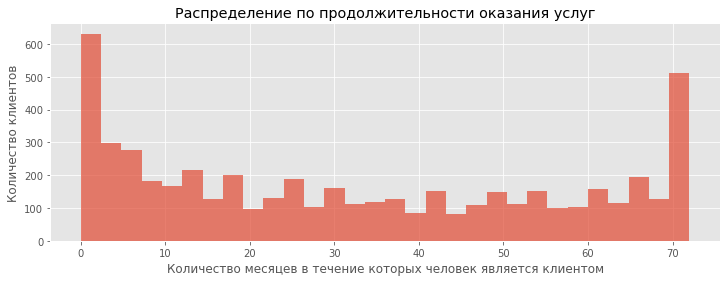

In [9]:
# Посмотрим на данные на гистограмме
fig, ax = plt.subplots(figsize=(12,4))

data_train['ClientPeriod'].hist(alpha=0.7, bins=30)

ax.set_title('Распределение по продолжительности оказания услуг')
ax.set_xlabel('Количество месяцев в течение которых человек является клиентом')
ax.set_ylabel('Количество клиентов')

На деле, мы видим достаточтно необычное распределение. У компании большое количество "молодых" пользователей, которые являются её клиентами достаточно непродолжительный срок. Затем мы видим примерно одинаковое количество клиентов с разными сроками продолжительности сотрудничества с компанией и большой пик у 72 месяцев. Последний объяснятся большим количеством лояльных клиентов — вероятно данные были выгружены за последние 6 лет, и в эту корзину попали все постоянные клиенты.

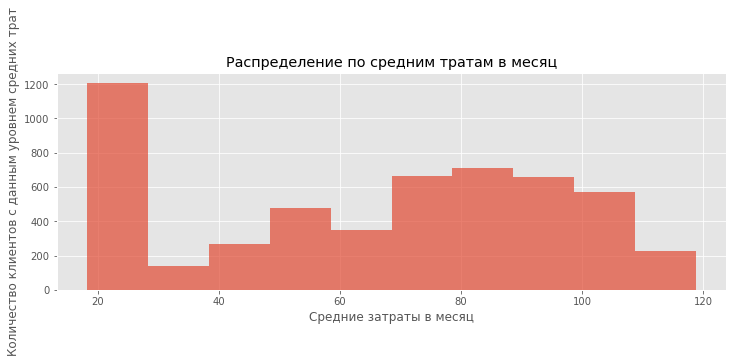

In [10]:
fig, ax = plt.subplots(figsize=(12,4))

data_train['MonthlySpending'].hist(alpha=0.7, bins=10)

ax.set_title('Распределение по средним тратам в месяц')
ax.set_xlabel('Средние затраты в месяц')
ax.set_ylabel('Количество клиентов с данным уровнем средних трат');

По затратам картинка распределения немного другая — большое количетсво клиентов тратит совсем немного условных единиц в месяц — они дают высокий пик около 20 у.е. Остальные клиенты распределены условно нормально, с пиком около 80 у.е. При этом среднее значение имеет значение 64 у.е. — как раз из-за большой доли клиентов с небольшими тратами, а также небольшой "просадкой" распределения в промежутке между 50 до 70 у.е. 

Признак `TotalSpent` имеет тип данных `object`, что говорит об ошибке выгрузки данных.

In [11]:
# data_train['TotalSpent'].astype('float32')

Вызов метода конверсии типа данных `.astype` дает ошибку из-за невозможности обработать часть данных — часть данных записаны как пустые значени ``.

In [12]:
data_train['TotalSpent'] = data_train['TotalSpent'].replace(to_replace=' ', value=0) # меняем пустые строки на нули
data_train['TotalSpent'] = data_train['TotalSpent'].astype('float32')                # меняем тип данных

Посмотрим на строки с нулевыми значениями.

In [13]:
data_train[data_train['TotalSpent']==0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,0.0,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,0.0,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,0.0,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,0.0,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,0.0,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,0.0,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,0.0,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,0.0,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,0.0,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Таких объектов оказалось совсем немного. Можно, предположить, что у клиентов, у которых признак `TotalSpent` не был заполнен, `ClientPeriod` имеет нулевое значение — т.е. вероятно, еще не закончился их первый месяц в качестве клиента для расчета общих затрат.

Отметим, что у признаков имеется сильная корреляция, что не очень хорошо для линейных моделей:

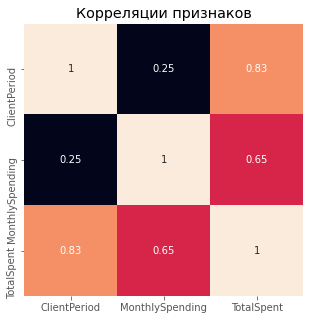

In [14]:
fig = plt.figure(figsize=(5,5))

sns.heatmap(data_train[['ClientPeriod','MonthlySpending','TotalSpent']].corr(),
            annot = True,
            cbar=False)
plt.title('Корреляции признаков');

#### Категориальные признаки в data_train

In [15]:
#Определим список категориальных признаков.

cat_features = ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
                'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService',
                'HasOnlineBackup', 'HasDeviceProtection','HasTechSupportAccess', 'HasOnlineTV',
                'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless','PaymentMethod']

Удобнее всего посмотреть на распределение категориальныхъ признаков будет на круговых диаграммах. Там же мы увидим аномальные значения, если они есть.

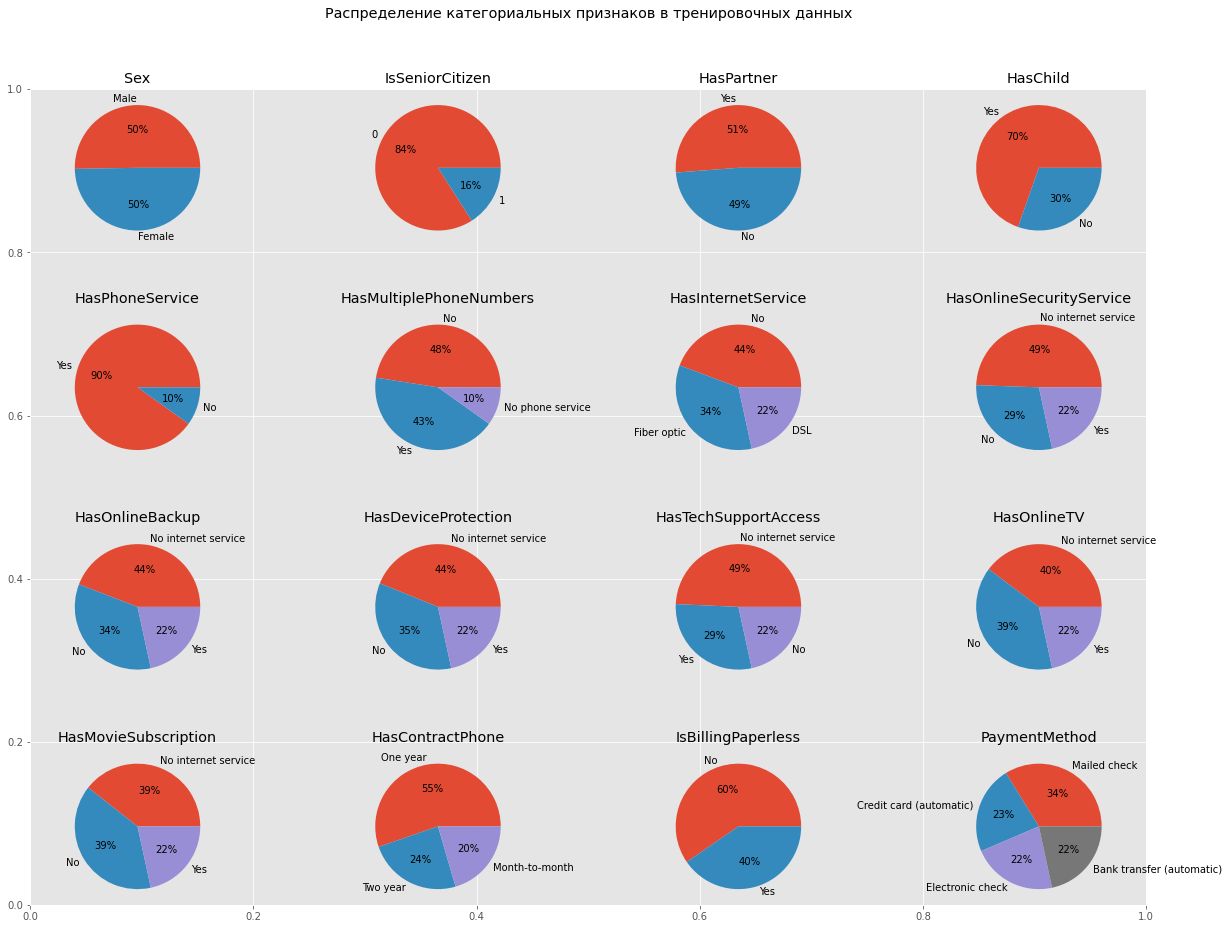

In [16]:
fig = plt.figure(figsize=(20,15), facecolor=None)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title('Распределение категориальных признаков в тренировочных данных', y=1.08)

for i, feature in enumerate(cat_features, start=1):
    ax = fig.add_subplot(4,4,i)
    
    ax.pie(data_train[feature].value_counts(), labels=data_train[feature].unique(), autopct='%1.0f%%')
    ax.set_title(feature)
    
    

Из круговых диаграмм мы видим следующее:
- в тестовой выборке одинаковое количество мужчин и женщин;
- пожилых граждан 16%;
- холостых и имеющих партнера почти одинаковое количество;
- преобладают клиенты с детьми;
- услуги связи получают 90%, из них 47.7% (43% от генеральной совокупности) имеют больше одного телефонного номера;
- В информации о том, кто использует интернет имеются разночтения — в самом признаке указано, что 44% клиентов не используют интернет, однако в других признаках по используемым услугам указано, что интернет не исрользуют от 39 до 49%;
- Каждый дополнительный сервис использует примерно 22% клиентов (вероятно, это одни и те же лояльные пользователи, пользующиеся полным пакетом услуг).
- 60% клиентов все ещеполучают счета в традиционном бумажном виде.
- 45% клиентов подключили автоматическую оплату счетов.

Наконец, посмотрим на распределние целевого признака

Text(0.5, 1.0, 'Churn')

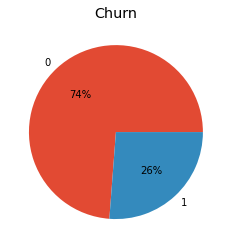

In [17]:
ax = plt.axes()

plt.title('Распределение целевого признака в тренировочных данных', y=1.08)

ax.pie(data_train['Churn'].value_counts(), labels=data_train['Churn'].unique(), autopct='%1.0f%%')
ax.set_title('Churn')

У нас имеется дисбаланс классов, что важно учесть при обучении модели

### Тестовые данные

In [18]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

В тестовых данных имеются все те же признаки, за исключением целевого `churn`

In [19]:
# аналогичное преобразование для TotalSpent

data_test['TotalSpent'] = data_test['TotalSpent'].replace(to_replace=' ', value=0) # меняем пустые строки на нули
data_test['TotalSpent'] = data_test['TotalSpent'].astype('float32')                # меняем тип данных

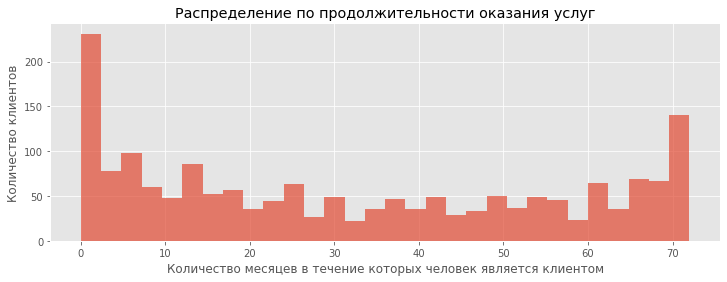

In [20]:
# Посмотрим на данные на гистограмме
fig, ax = plt.subplots(figsize=(12,4))

data_test['ClientPeriod'].hist(alpha=0.7, bins=30)

ax.set_title('Распределение по продолжительности оказания услуг')
ax.set_xlabel('Количество месяцев в течение которых человек является клиентом')
ax.set_ylabel('Количество клиентов');

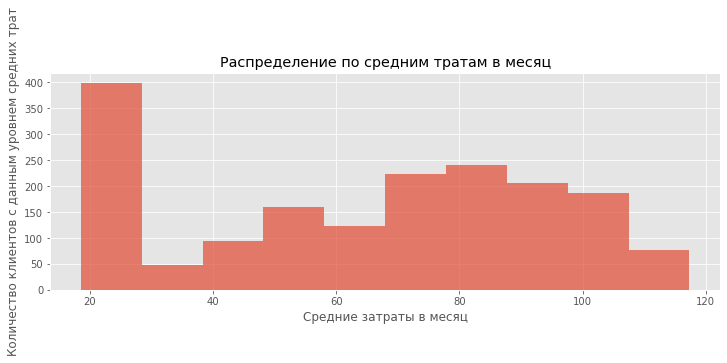

In [21]:
fig, ax = plt.subplots(figsize=(12,4))

data_test['MonthlySpending'].hist(alpha=0.7, bins=10)

ax.set_title('Распределение по средним тратам в месяц')
ax.set_xlabel('Средние затраты в месяц')
ax.set_ylabel('Количество клиентов с данным уровнем средних трат');

Количественные признаки распределены также как и в тренировочной выборке.

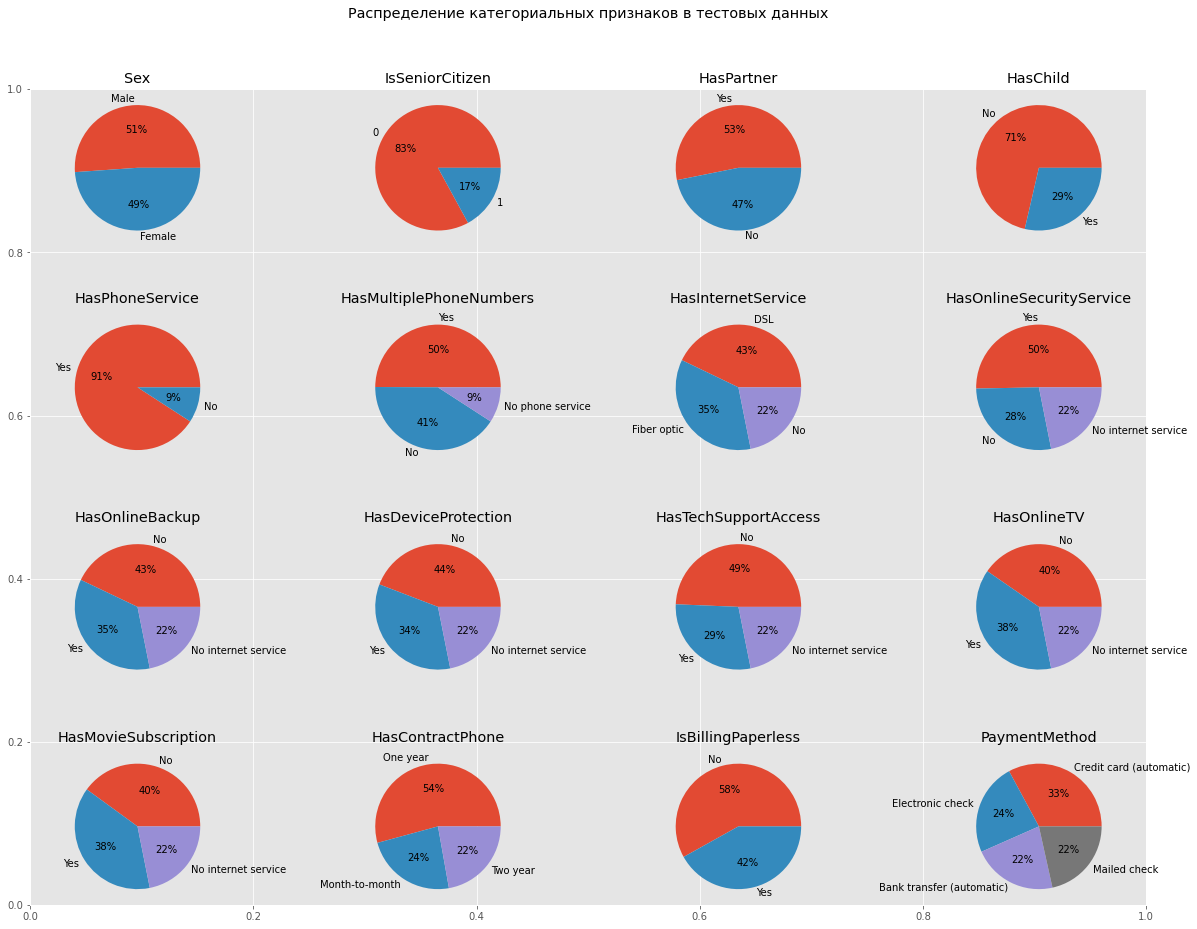

In [22]:
fig = plt.figure(figsize=(20,15), facecolor=None)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title('Распределение категориальных признаков в тестовых данных', y=1.08)

for i, feature in enumerate(cat_features, start=1):
    ax = fig.add_subplot(4,4,i)
    
    ax.pie(data_test[feature].value_counts(), labels=data_test[feature].unique(), autopct='%1.0f%%')
    ax.set_title(feature)
    

В категориальных признаках есть некоторые отличия. Например, сильно ниже количество клиентов не использующих интернет сервисы — 22% против 40% в тренировочной. Можно предположить, что тестовые данные выгружались чуть позже, с развитием проникновения интернета.

## Обучение моделей

### Отделение целевого признака

In [23]:
target_train = data_train['Churn']
features_train = data_train.drop(columns='Churn')

In [24]:
features_train.shape

(5282, 19)

In [25]:
target_train.shape

(5282,)

In [26]:
features_test = data_test

### Логистическая регрессия

#### Нормализация данных и прямое кодирование категориальных признаков

Перед обучение модели по алгоритму Логистической регрессии преобразуем категориальные признаки и произведем их нормирование

In [27]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)

In [28]:
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

In [29]:
scaler = StandardScaler() # создаем объект для нормирования
features_train_ohe_scaled = scaler.fit_transform(features_train_ohe)
features_test_ohe_scaled = scaler.transform(features_test_ohe)

#### Подбор гиперпараметров и обучение модели

Теперь необходимо создать словарь гиперпараметров для перебора по сетке:

In [30]:
model = LogisticRegression(random_state = 1049, class_weight='balanced') #создаем объект модели

In [31]:
parametrs = {'penalty' : ['l2', 'elasticnet'],
             'max_iter' : [50, 100, 200, 500],
             'solver' : ['liblinear', 'saga']}

grid = GridSearchCV(model, parametrs, scoring = 'roc_auc', cv=5)
grid.fit(features_train_ohe_scaled, target_train)
grid.best_params_

C:\Users\rizho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\rizho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

{'max_iter': 50, 'penalty': 'l2', 'solver': 'saga'}

#### Предсказание на тесте

In [32]:
predictions_lr = np.round(grid.predict_proba(features_test_ohe_scaled), 2)

In [33]:
predictions_lr[:,1]

array([0.11, 0.88, 0.85, ..., 0.89, 0.83, 0.03])

In [34]:
predictions_lr_round = pd.DataFrame({'Id' : list(range(len(features_test_ohe_scaled))), 'Churn': predictions_lr[:,1]})
predictions_lr_round.to_csv("submission_lr_round.csv", index=False)

Данный сабмишн дает на тестовых данных метрику ROC-AUC равную 0.8458

Посмотрим, как справится более сложная модель

### CatBoostClassifier

CatBoostRegressor может напрямую работать с категориальными признаками, OHE не понадобится.

#### Перебор гиперпараметров

In [39]:
model = CatBoostClassifier(cat_features=cat_features,
                           random_state = 1049, verbose=1000,
                           eval_metric='AUC:hints=skip_train~false',
                           grow_policy='Lossguide')

In [40]:
grid = {'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [1, 2, 4, 50, 100],
        "min_data_in_leaf":[2, 50, 100]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       cv=5,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6731359	test: 0.6883741	best: 0.6883741 (0)	total: 4.01ms	remaining: 4s
999:	learn: 0.8434870	test: 0.8737605	best: 0.8737605 (999)	total: 5.28s	remaining: 0us

bestTest = 0.8737604609
bestIteration = 999

0:	loss: 0.8737605	best: 0.8737605 (0)	total: 5.39s	remaining: 3m 57s
0:	learn: 0.6731359	test: 0.6883741	best: 0.6883741 (0)	total: 3.65ms	remaining: 3.64s
999:	learn: 0.8557576	test: 0.8717065	best: 0.8739467 (178)	total: 5.47s	remaining: 0us

bestTest = 0.87394675
bestIteration = 178

1:	loss: 0.8739467	best: 0.8739467 (1)	total: 10.9s	remaining: 3m 54s
0:	learn: 0.6731359	test: 0.6883741	best: 0.6883741 (0)	total: 4.05ms	remaining: 4.04s
999:	learn: 0.8631965	test: 0.8693277	best: 0.8746537 (35)	total: 5.31s	remaining: 0us

bestTest = 0.8746536933
bestIteration = 35

2:	loss: 0.8746537	best: 0.8746537 (2)	total: 16.2s	remaining: 3m 47s
0:	learn: 0.7329286	test: 0.7559565	best: 0.7559565 (0)	total: 8.99ms	remaining: 8.98s
999:	learn: 0.8518774	test: 0.8721340	best: 0.8

Неожиданно, лучшую метрику показала "пеньковая" модель с глубиной дерева 1 — такие деревья не переобучаются

In [41]:
predictions_cb = model.predict_proba(features_test)

In [42]:
predictions_cb_round = pd.DataFrame({'Id' : list(range(len(features_test_ohe_scaled))),
                                     'Churn': np.round(predictions_cb[:,1], 2)})
# predictions_cb_round.to_csv("submission_cb_round.csv", index=False)

In [43]:
predictions_cb_round.to_csv("submission.csv", index=False)

Данный сабмит дает метрику 0.8526 (против 0.8458 у логистической регресии)